In [1]:
import torch
import torch.nn as nn

In [2]:
import gymnasium as gym

env = gym.make("ALE/Kaboom-v5", render_mode='rgb_array')
from nn_model3 import DQNEfficientNet
model = DQNEfficientNet(env.action_space.n)

wei = torch.load("trains/model_1690.pth", weights_only=True)
# wei = torch.load("trains/model_0.pth", weights_only=True)
model.load_state_dict(wei)
for param in model.parameters():
    print(f'number of parameters:{param.numel(): 12d} {param.shape}')

number of parameters:        6144 torch.Size([32, 3, 8, 8])
number of parameters:          32 torch.Size([32])
number of parameters:       32768 torch.Size([64, 32, 4, 4])
number of parameters:          64 torch.Size([64])
number of parameters:       36864 torch.Size([64, 64, 3, 3])
number of parameters:          64 torch.Size([64])
number of parameters:       36864 torch.Size([64, 64, 3, 3])
number of parameters:          64 torch.Size([64])
number of parameters:       73728 torch.Size([128, 64, 3, 3])
number of parameters:         128 torch.Size([128])
number of parameters:       18432 torch.Size([256, 8, 3, 3])
number of parameters:         256 torch.Size([256])
number of parameters:       65536 torch.Size([256, 256])
number of parameters:         256 torch.Size([256])
number of parameters:       32768 torch.Size([128, 256])
number of parameters:         128 torch.Size([128])
number of parameters:         512 torch.Size([4, 128])
number of parameters:           4 torch.Size([4])


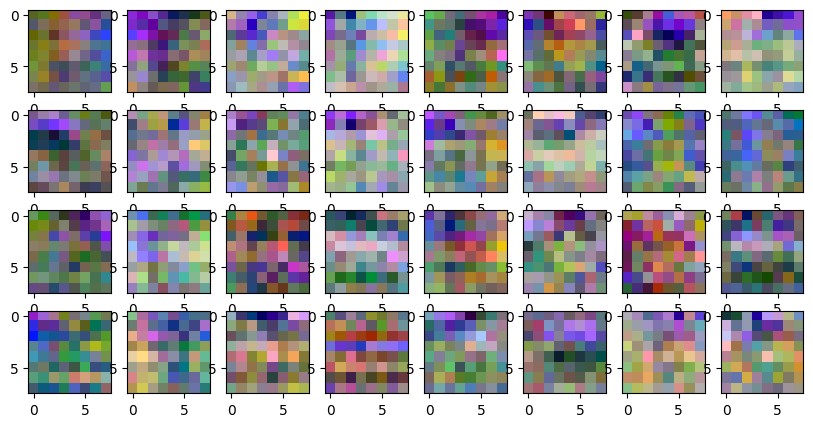

In [3]:
import matplotlib.pyplot as plt
fig, axs =  plt.subplots(4,8,figsize=(10, 5))
for c in range(32):
    with torch.no_grad():
        max = model.features[0].weight[c].max().item()
        min = model.features[0].weight[c].min().item()
        img_norm = (model.features[0].weight[c].permute(1,2,0).numpy()-min)/(max - min)
        # print(max, min)
        axs[c//8][c%8].imshow(img_norm)

In [4]:
import cv2
state,_ = env.reset()
def obs2stateTensor(obs, show=False):
    # obs = obs[:, 420:1500] # choose area for model input
    # state = cv2.resize(obs, (224, 224))
    state = obs
    if(show): 
        cv2.imshow('model input', cv2.cvtColor(state, cv2.COLOR_RGB2BGR))
        cv2.waitKey(1)
    state = torch.FloatTensor(state)
    state = state.permute(2, 0, 1).contiguous()  # (H, W, C) -> C, H, W
    state = (state - state.mean())/state.std() # normalize
    return state

torch.Size([64, 7, 6])


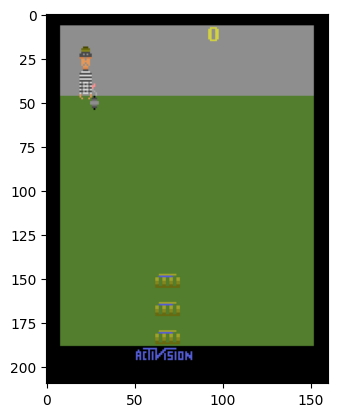

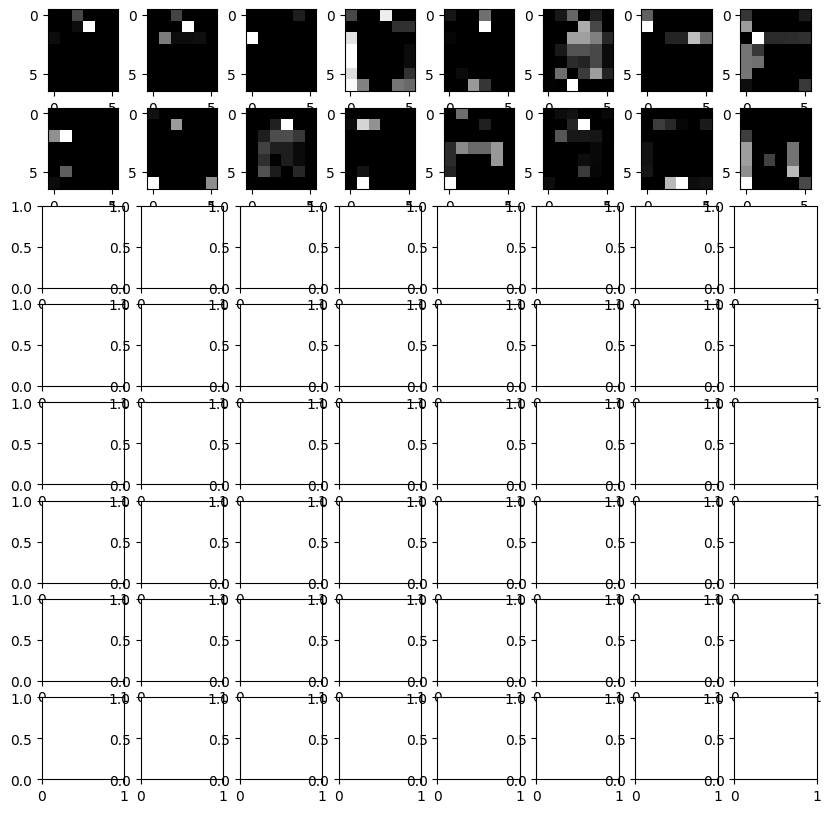

In [5]:
img_axs = plt.subplot()
fig, axs =  plt.subplots(8,8,figsize=(10, 10))
with torch.no_grad():
    state, reward, done,trancated, info = env.step(env.action_space.sample())
    img_axs.imshow(state)
    state = obs2stateTensor(state, show=False)
    afterCNN = model.features[0:8](state)
    print(afterCNN.shape)
    for c in range(16):
        axs[c//8][c%8].imshow(afterCNN[c], cmap='gray')

In [6]:
state,_ = env.reset()

torch.Size([64, 15, 12])
torch.Size([120, 96])


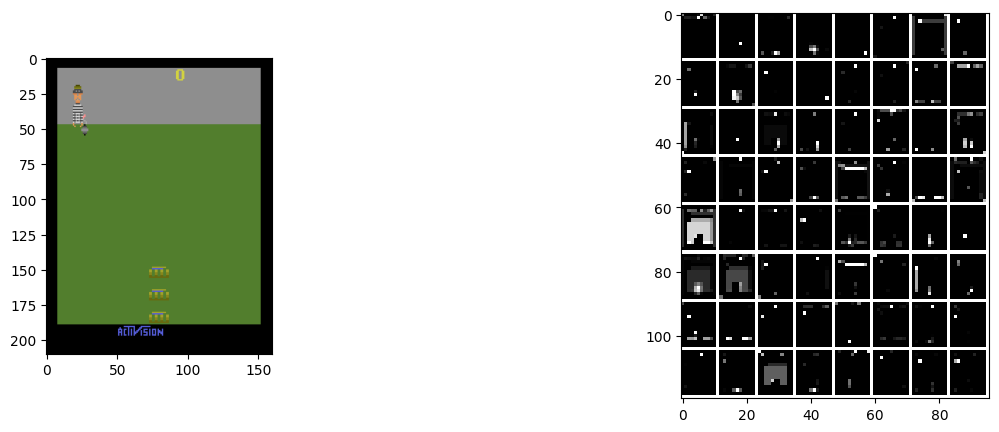

In [7]:
# img_axs = plt.subplot()
fig, axs =  plt.subplots(1,2,figsize=(16, 5), gridspec_kw={'width_ratios': [1, 4]})

with torch.no_grad():
    state, reward, done,trancated, info = env.step(env.action_space.sample())
    axs[0].imshow(state)
    state = obs2stateTensor(state, show=False)
    afterCNN = model.features[0:6](state)
    #normalize each img
    max = afterCNN.amax(dim= (-1,-2), keepdim=True)
    min = afterCNN.amin(dim= (-1,-2), keepdim=True)
    afterCNN = (afterCNN - min)/(max - min + 1e-8)    
    afterCNN = torch.nn.functional.pad(afterCNN, (0, 1, 0, 1), mode='constant',value=1) # pad to add border
    print(afterCNN.shape)
    img_w = afterCNN.shape[-1]
    img_h = afterCNN.shape[-2]
    img_c = afterCNN.shape[-3]
    afterCNN = afterCNN.reshape(-1,8,img_h,img_w).permute(0,2,1,3).reshape(-1,8*img_w)
    print(afterCNN.shape)
    axs[1].imshow(afterCNN, cmap='gray')
    # print(cv2.resize((afterCNN.unsqueeze(-1)*torch.ones(3)).numpy(), (420, afterCNN.shape[-1]*320/afterCNN.shape[-2])).shape)
    
    # for c in range(16):
    #     axs[c//8][c%8].imshow(afterCNN[c], cmap='gray')

In [8]:
model

DQNEfficientNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
    (11): ReLU()
    (12): AdaptiveMaxPool2d(output_size=1)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [12]:
# Play the game use the model and display interal CNN features
import time
import numpy as np
cnn_layer = 6
num_img_horiz = 8
obs,_ = env.reset()
for i in range(10000000):
    with torch.no_grad():
        state = obs2stateTensor(obs, show=False)
        q_values = model(state.unsqueeze(0))
        action = q_values.argmax().item() 
        obs, reward, done,trancated, info = env.step(action)
        if(done):
            obs,_ = env.reset()
            print('Started new game')
            continue
        afterCNN = model.features[0:cnn_layer](state)
        #normalize each img
        # max = afterCNN.amax(dim= (-1,-2), keepdim=True)
        # min = afterCNN.amin(dim= (-1,-2), keepdim=True)
        max = afterCNN.max()
        min = afterCNN.min()
        afterCNN = (afterCNN - min)/(max - min + 1e-8)    
        afterCNN = torch.nn.functional.pad(afterCNN, (0, 1, 0, 1), mode='constant',value=1) # pad to add border
        # print(afterCNN.shape)
        img_w = afterCNN.shape[-1]
        img_h = afterCNN.shape[-2]
        img_c = afterCNN.shape[-3]
        afterCNN = afterCNN.reshape(-1,num_img_horiz,img_h,img_w).permute(0,2,1,3).reshape(-1,num_img_horiz*img_w)
        # print(afterCNN.shape)
        # print((afterCNN).max())
        state = cv2.cvtColor(obs.astype(np.float32)/200, cv2.COLOR_RGB2BGR)
        cv_img = cv2.hconcat([cv2.resize(state,(640,840), interpolation=cv2.INTER_AREA), 
                            cv2.resize((afterCNN.unsqueeze(-1)*torch.ones(3)).numpy(), (int(afterCNN.shape[-1]*840/afterCNN.shape[-2]), 840)
                                       ,interpolation=cv2.INTER_AREA)])
        cv2.imshow('Game Analysis', cv_img)
        cv2.waitKey(1)
        time.sleep(0.05)

KeyboardInterrupt: 